In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beginners-prediction-task/submit_submit.csv
/kaggle/input/beginners-prediction-task/data description.txt
/kaggle/input/beginners-prediction-task/train.csv
/kaggle/input/beginners-prediction-task/test.csv


In [2]:
#Basic info on the data 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/kaggle/input/beginners-prediction-task/train.csv")  # Update path if needed

# Basic info
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nStatistical Summary:\n", df.describe())

Dataset shape: (340, 32)

Missing values:
 ID                                                   0
name                                                 0
gender                                               0
ethnicity                                            0
religion                                             0
state_of_origin                                      0
age                                                  0
hobby                                                0
school_type                                          0
parental_education_level                             0
extracurricular_activity                             0
learning_disability                                  0
school_location                                      0
tutoring_mentoring_program                           0
parental_involvement_level                           0
bullying_experience                                  0
study_time                                           0
attendance_percentage 

/tmp/ipykernel_13/3428045235.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['attendance_percentage'].fillna(df['attendance_percentage'].median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


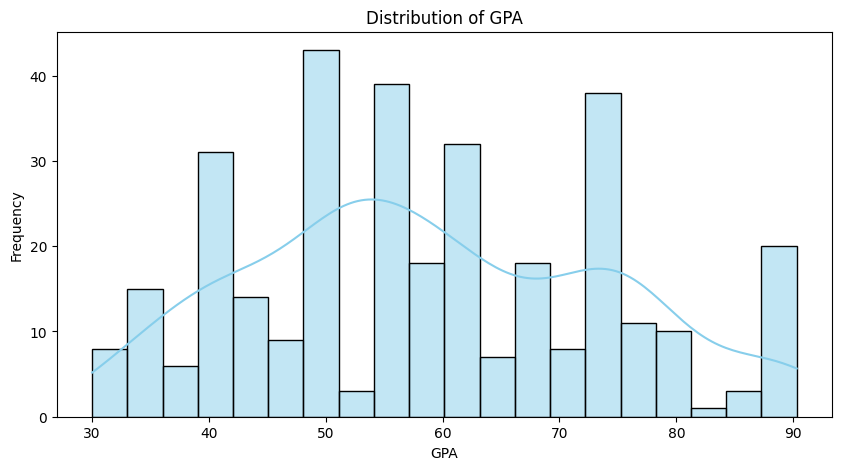

In [3]:
#fixing errors and missing values
# Fixing obvious data errors
df = df[df['age'] > 0]
df = df[df['study_time'] < 50]
df = df[df['exam_social_science'] < 150]  # Based on other exam scales

# Fill missing attendance with median
df['attendance_percentage'].fillna(df['attendance_percentage'].median(), inplace=True)

# ---------------------
# GPA Distribution
# ---------------------
plt.figure(figsize=(10, 5))
sns.histplot(df['gpa'], kde=True, bins=20, color='skyblue')
plt.title("Distribution of GPA")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.show()

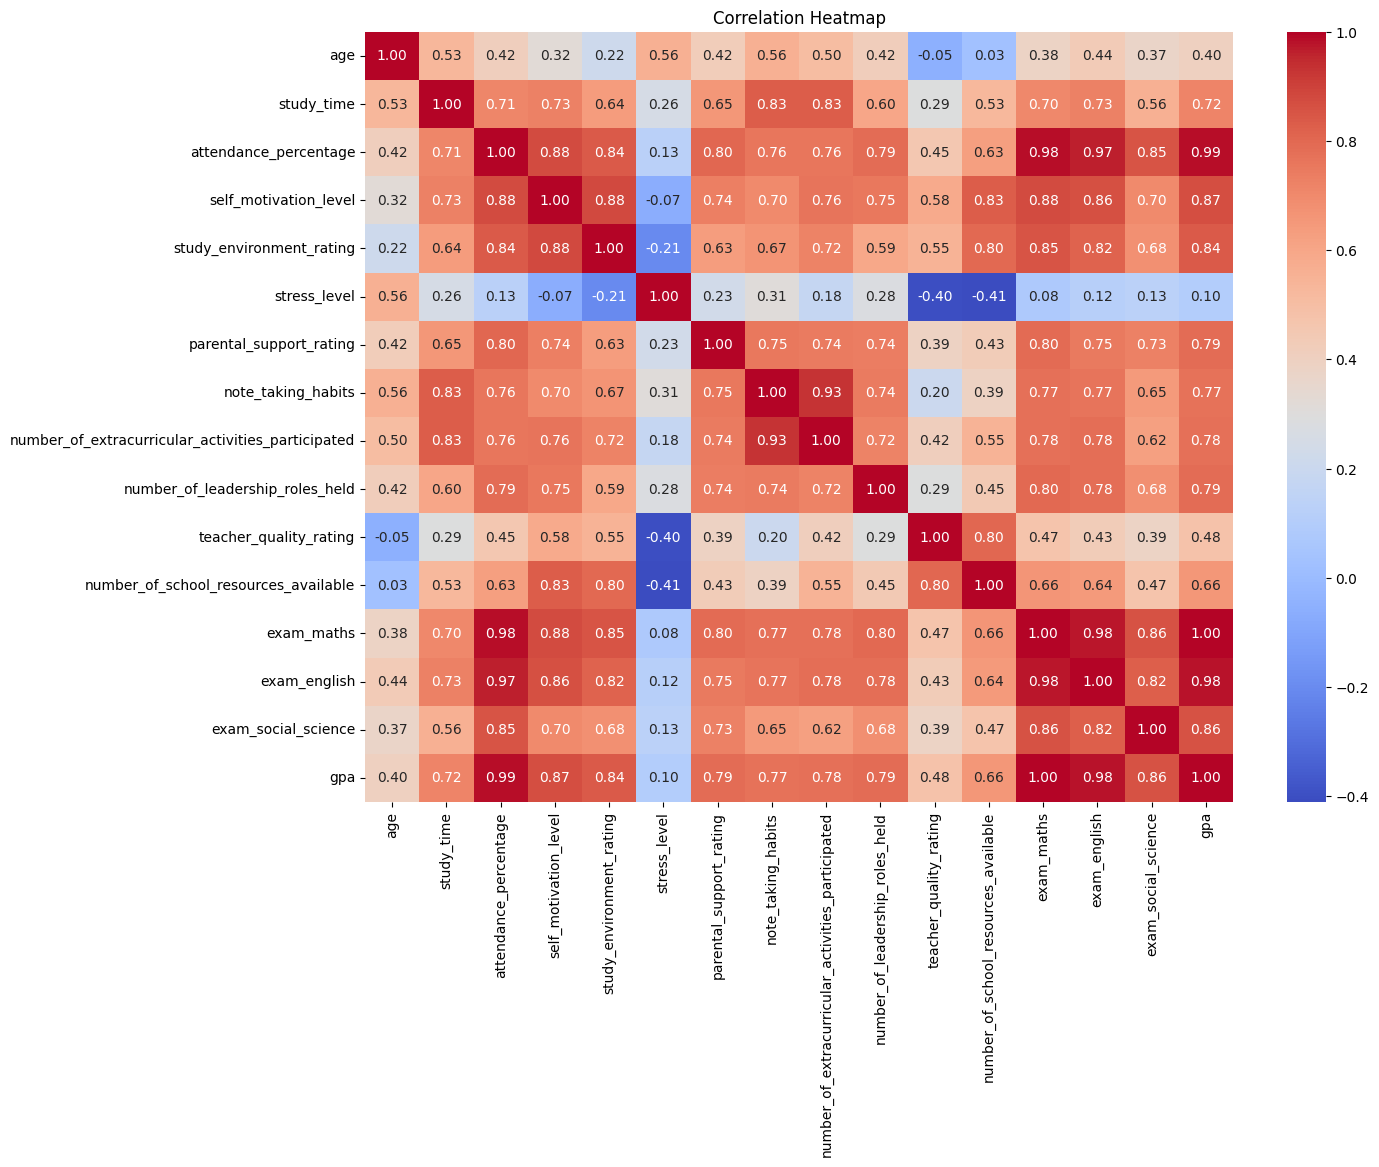

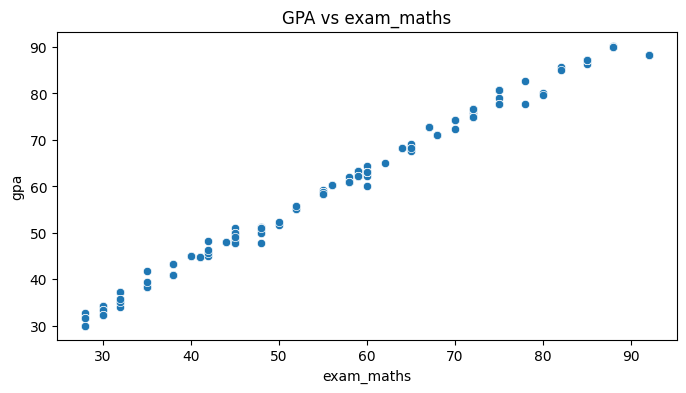

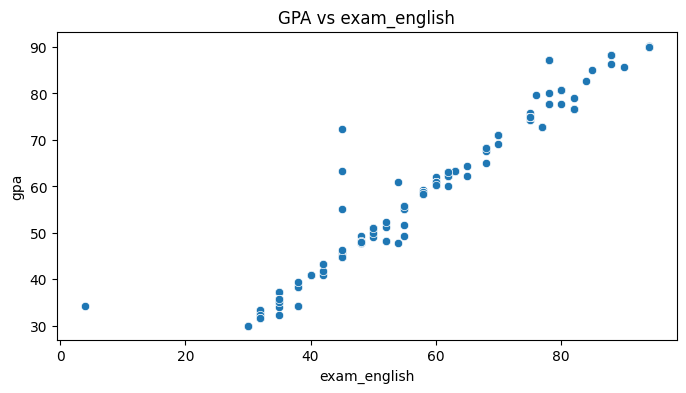

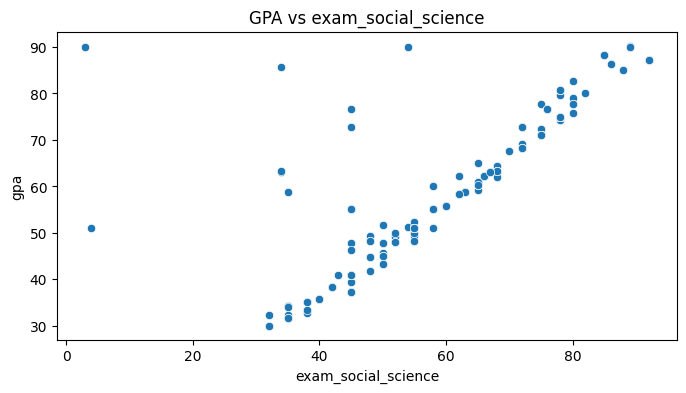

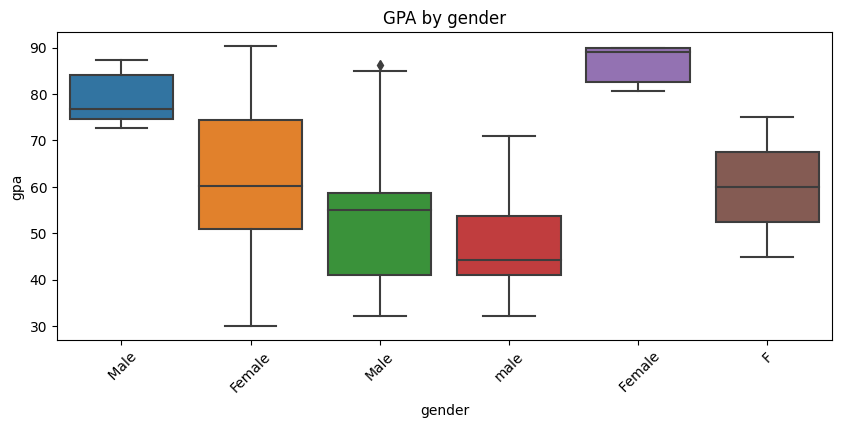

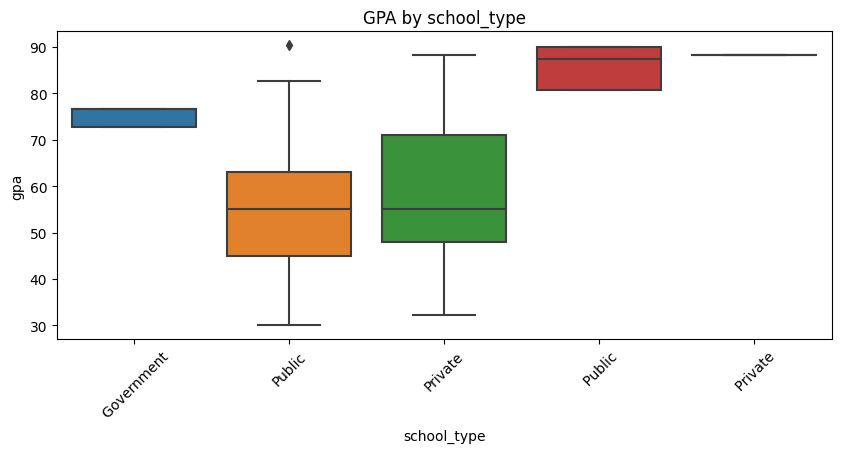

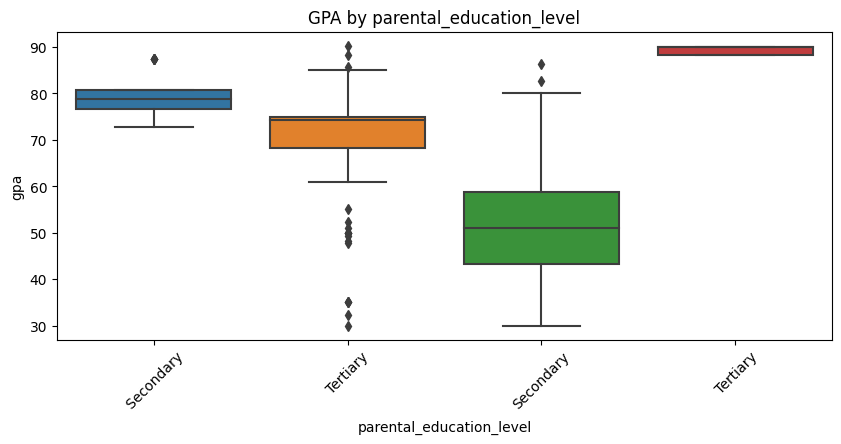

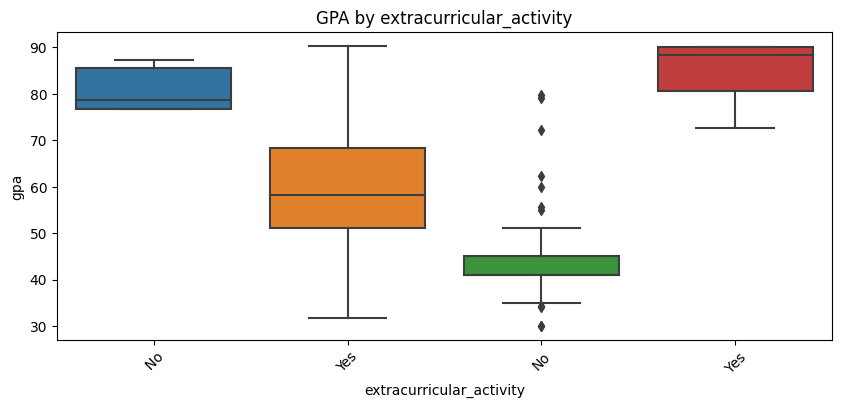

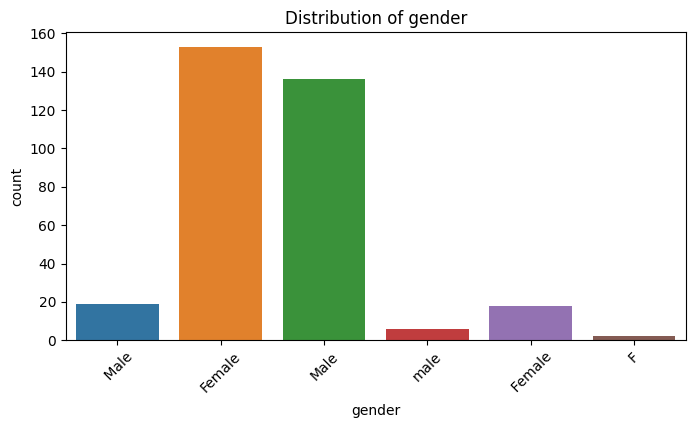

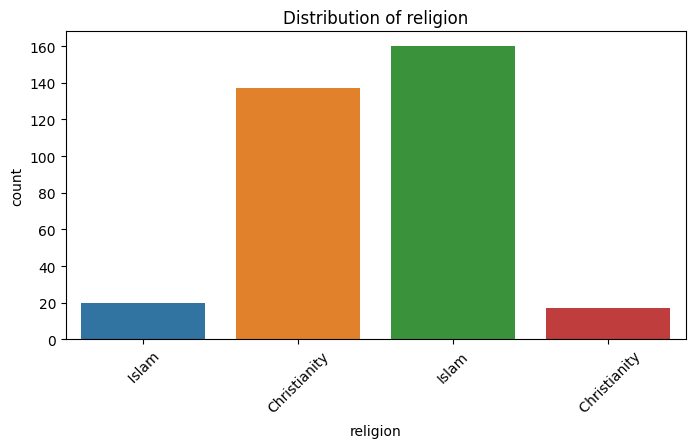

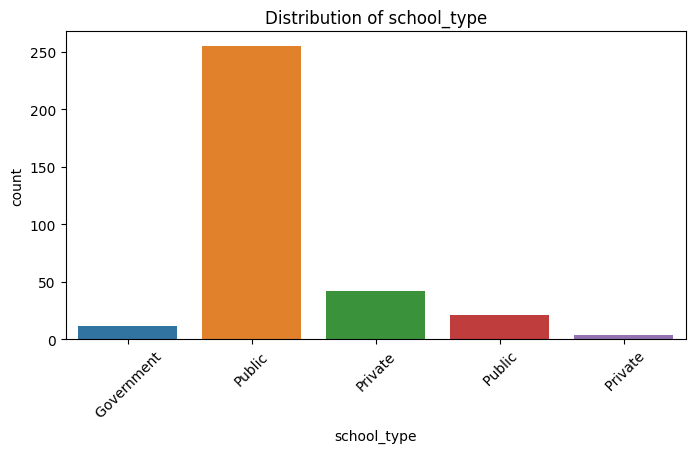

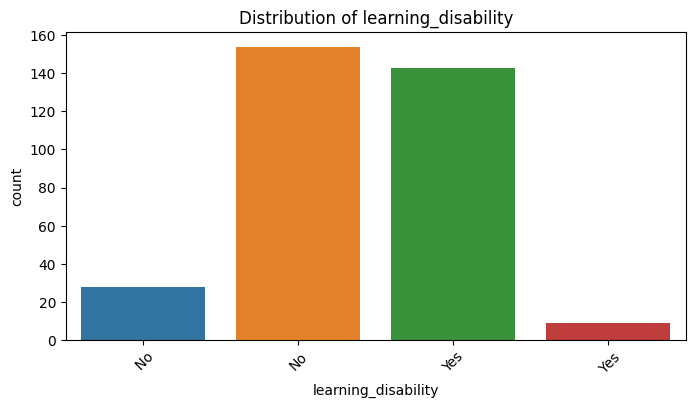

In [4]:
#feature selection
# Correlation Heatmap
# ---------------------
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numerical_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ---------------------
# GPA vs Exam Scores
# ---------------------
exam_cols = ['exam_maths', 'exam_english', 'exam_social_science']
for col in exam_cols:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x=col, y='gpa')
    plt.title(f"GPA vs {col}")
    plt.show()

# ---------------------
# Boxplots for categorical features vs GPA
# ---------------------
categorical_cols = ['gender', 'school_type', 'parental_education_level', 'extracurricular_activity']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=col, y='gpa')
    plt.title(f"GPA by {col}")
    plt.xticks(rotation=45)
    plt.show()

# ---------------------
# Count plots for key categorical variables
# ---------------------
for col in ['gender', 'religion', 'school_type', 'learning_disability']:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [5]:
# deal with outliers
from scipy.stats import zscore
import pandas as pd


# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_data = df[numerical_cols]

# Compute z-scores
z_scores = zscore(numerical_data)

# Create a mask for rows with all z-scores < 3
mask = (abs(z_scores) < 3).all(axis=1)

# Apply mask to remove outliers
df_clean = df[mask].reset_index(drop=True)

# Check how much data was removed
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


Original shape: (334, 32)
Cleaned shape: (302, 32)


In [6]:
# converting categorical data to numerical data 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Drop columns not useful for prediction
df_clean.drop(columns=['ID', 'name', 'ethnicity', 'state_of_origin', 'hobby'], inplace=True)

# Separate features and target
X = df_clean.drop('gpa', axis=1)
y = df_clean['gpa']

# Label encoding columns (ordinal)
label_encode_cols = ['parental_education_level', 'peer_interaction_level', 'parental_involvement_level']
for col in label_encode_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Identify numeric and remaining categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Create pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Fit and transform
X_encoded = preprocessor.fit_transform(X)

print("Encoded feature matrix shape:", X_encoded.shape)


Encoded feature matrix shape: (302, 47)


In [7]:
#building a basic model first before feature selection .
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 2: Train basic Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline R² Score: {r2:.2f}")


Baseline RMSE: 1.39
Baseline R² Score: 0.99


In [8]:
# Step 3: Get feature importances
importances = model.feature_importances_

# Extract one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(ohe_feature_names)

# Create DataFrame of importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 6 Features:")
print(feature_importance_df.head(15))

#Retrain the top 15 features.
top_features = feature_importance_df['Feature'].head(15).tolist()

# Step 2: Reconstruct X_encoded into a DataFrame
# (convert to dense if it's sparse)
X_encoded_df = pd.DataFrame(
    X_encoded.toarray() if hasattr(X_encoded, 'toarray') else X_encoded,
    columns=feature_importance_df['Feature'].tolist()
)

# Step 3: Filter to top 15 features only
X_top = X_encoded_df[top_features]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest model
model_top = RandomForestRegressor(n_estimators=100, random_state=42)
model_top.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model_top.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Top 6 Features:
                       Feature  Importance
15                  exam_maths    0.717752
16                exam_english    0.242141
4        attendance_percentage    0.026725
17         exam_social_science    0.009975
0                          age    0.000466
6     study_environment_rating    0.000315
7                 stress_level    0.000247
14      peer_interaction_level    0.000208
3                   study_time    0.000184
20               gender_Female    0.000148
29          school_type_Public    0.000144
9           note_taking_habits    0.000137
39    school_location_Suburban    0.000131
1     parental_education_level    0.000127
2   parental_involvement_level    0.000107
RMSE: 1.68
R² Score: 0.986


In [9]:
print("Min GPA:", y.min())
print("Max GPA:", y.max())

Min GPA: 30.0
Max GPA: 85.0


In [10]:
# training using the xgboost regressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Reuse the top 10 selected features from RFE
X_encoded_df = pd.DataFrame(
    X_encoded.toarray() if hasattr(X_encoded, 'toarray') else X_encoded,
    columns=all_feature_names
)

X_rfe = X_encoded_df[top_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R² Score: {r2:.3f}")


XGBoost RMSE: 0.93
XGBoost R² Score: 0.996


In [11]:
 #training on test data 
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# === Step 1: Load test data ===
# Adjust path if needed
test_df = pd.read_csv("/kaggle/input/beginners-prediction-task/test.csv")

# === Step 2: Save original IDs for submission ===
test_ids = test_df['ID']

# === Step 3: Drop non-informative or unnecessary columns (as done in training) ===
test_df.drop(columns=['ID', 'name', 'ethnicity', 'state_of_origin', 'hobby'], inplace=True)

# === Step 4: Handle missing values consistently ===
# Replace missing attendance with median from training data (assume df is your training DataFrame)
test_df['attendance_percentage'].fillna(df['attendance_percentage'].median(), inplace=True)

# === Step 5: Encode ordinal features ===
ordinal_cols = ['parental_education_level', 'peer_interaction_level', 'parental_involvement_level']
for col in ordinal_cols:
    le = LabelEncoder()
    le.fit(df[col])  # use training data's encoder
    test_df[col] = le.transform(test_df[col])

# === Step 6: Apply preprocessing pipeline ===
X_test_transformed = preprocessor.transform(test_df)

# === Step 7: Convert transformed data to DataFrame ===
X_test_encoded_df = pd.DataFrame(
    X_test_transformed.toarray() if hasattr(X_test_transformed, 'toarray') else X_test_transformed,
    columns=all_feature_names
)

# === Step 8: Select same features as training ===
X_test_selected = X_test_encoded_df[top_features]

# === Step 9: Predict using trained XGBoost model ===
test_predictions = xgb_model.predict(X_test_selected)

# === Step 10: Create submission DataFrame ===
submission_df = pd.DataFrame({
    'ID': test_ids,
    'Predicted_GPA': test_predictions
})

# === Step 11: Save to CSV ===
submission_df.to_csv("predicted_gpa_submission.csv", index=False)

# Preview results
print(submission_df.head())


         ID  Predicted_GPA
0  f3cc1652      55.097187
1  742d0f23      72.701302
2  55c8eb81      62.351944
3  8cc561eb      41.043018
4  44e51687      61.030132


/tmp/ipykernel_13/2158625770.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['attendance_percentage'].fillna(df['attendance_percentage'].median(), inplace=True)
